# 1. Importing Libraries


In [2]:
!pip install ultralytics 


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.8/883.8 kB 8.0 MB/s eta 0:00:00:00:01


In [3]:
import os
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import cv2
import random
import matplotlib.image as mpimg
import warnings
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import *
from tensorflow.keras.callbacks import EarlyStopping , ReduceLROnPlateau
from tensorflow.keras.preprocessing.image import ImageDataGenerator , load_img
from sklearn.metrics import classification_report, confusion_matrix, f1_score
from sklearn.utils import class_weight
from tensorflow.keras.applications import DenseNet121
import albumentations as A
from albumentations.pytorch import ToTensorV2
from keras import backend as keras
from ultralytics import YOLO
from tensorflow.keras.preprocessing.image import load_img, img_to_array

/opt/conda/lib/python3.10/site-packages/albumentations/__init__.py:13: UserWarning: A new version of Albumentations is available: 1.4.21 (you have 1.4.17). Upgrade using: pip install -U albumentations. To disable automatic update checks, set the environment variable NO_ALBUMENTATIONS_UPDATE to 1.
  check_for_updates()


Creating new Ultralytics Settings v0.0.6 file ✅ 
View Ultralytics Settings with 'yolo settings' or at '/root/.config/Ultralytics/settings.json'
Update Settings with 'yolo settings key=value', i.e. 'yolo settings runs_dir=path/to/dir'. For help see https://docs.ultralytics.com/quickstart/#ultralytics-settings.


# 2.Loading Dataset

In [5]:
!kaggle datasets download -d pkdarabi/bone-fracture-detection-computer-vision-project
!unzip bone-fracture-detection-computer-vision-project.zip > /dev/null

/opt/conda/lib/python3.10/pty.py:89: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  pid, fd = os.forkpty()


Dataset URL: https://www.kaggle.com/datasets/pkdarabi/bone-fracture-detection-computer-vision-project
License(s): Attribution 4.0 International (CC BY 4.0)
 87%|█████████████████████████████████▊     | 73.0M/84.1M [00:00<00:00, 171MB/s]
100%|███████████████████████████████████████| 84.1M/84.1M [00:00<00:00, 157MB/s]


In [4]:
train_images = '/kaggle/input/bone-fracture-detection-computer-vision-project/BoneFractureYolo8/train/images'
train_labels = '/kaggle/input/bone-fracture-detection-computer-vision-project/BoneFractureYolo8/train/labels'

test_images = '/kaggle/input/bone-fracture-detection-computer-vision-project/BoneFractureYolo8/test/images'
test_labels = '/kaggle/input/bone-fracture-detection-computer-vision-project/BoneFractureYolo8/train/labels'

val_images = '/kaggle/input/bone-fracture-detection-computer-vision-project/BoneFractureYolo8/valid/images'
val_labels = '/kaggle/input/bone-fracture-detection-computer-vision-project/BoneFractureYolo8/valid/labels'

In [5]:
print('Number of train frames: ' + str(len(os.listdir(train_images))))
print('Number of train labels: ' + str(len(os.listdir(train_labels))))
print('Number of val frames: ' + str(len(os.listdir(val_images))))
print('Number of val labels: ' + str(len(os.listdir(val_labels))))
print('Number of test frames: ' + str(len(os.listdir(test_images))))
print('Number of test labels: ' + str(len(os.listdir(test_labels))))
print('Total frames: ' + str(len(os.listdir(train_images)) + len(os.listdir(test_images)) + len(os.listdir(val_images))))

Number of train frames: 3631
Number of train labels: 3631
Number of val frames: 348
Number of val labels: 348
Number of test frames: 169
Number of test labels: 3631
Total frames: 4148


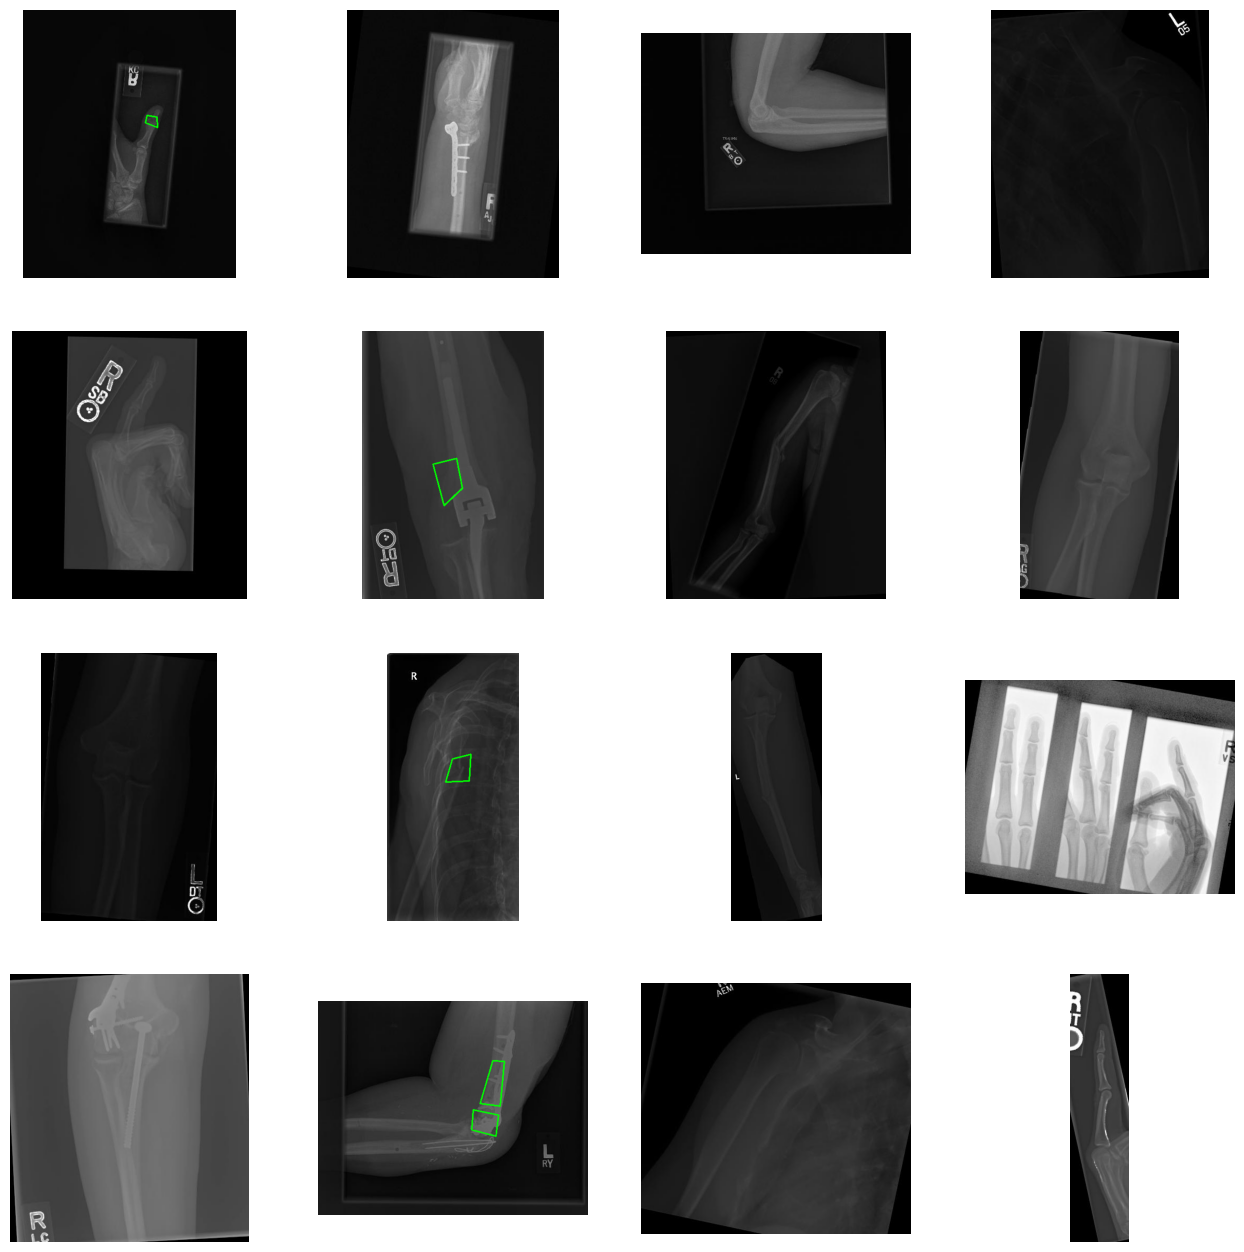

In [8]:
import os
import random
import cv2
import matplotlib.pyplot as plt

# Get a list of all the image files in the training images directory
image_files = os.listdir(train_images)

# Choose 16 random image files from the list
random_images = random.sample(image_files, 16)

# Set up the plot
fig, axs = plt.subplots(4, 4, figsize=(16, 16))

# Loop over the random images and plot the object detections
for i, image_file in enumerate(random_images):
    row = i // 4
    col = i % 4

    # Load the image
    image_path = os.path.join(train_images, image_file)
    image = cv2.imread(image_path)

    # Load the labels for this image
    label_file = os.path.splitext(image_file)[0] + ".txt"
    label_path = os.path.join(train_labels, label_file)
    with open(label_path, "r") as f:
        labels = f.read().strip().split("\n")

    # Loop over the labels and plot the object detections
    for label in labels:
        parts = label.split()
        if len(parts) == 9:  # Check if the line contains 1 class ID + 4 points
            class_id = int(parts[0])
            x1, y1, x2, y2, x3, y3, x4, y4 = map(float, parts[1:])
            
            # Convert normalized coordinates to pixel coordinates
            x1, y1 = int(x1 * image.shape[1]), int(y1 * image.shape[0])
            x2, y2 = int(x2 * image.shape[1]), int(y2 * image.shape[0])
            x3, y3 = int(x3 * image.shape[1]), int(y3 * image.shape[0])
            x4, y4 = int(x4 * image.shape[1]), int(y4 * image.shape[0])

            # Define points for the polygon
            points = np.array([[x1, y1], [x2, y2], [x3, y3], [x4, y4]], np.int32)
            points = points.reshape((-1, 1, 2))
            
            # Draw the polygon on the image
            cv2.polylines(image, [points], isClosed=True, color=(0, 255, 0), thickness=2)

    # Show the image with the object detections
    axs[row, col].imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
    axs[row, col].axis('off')

plt.show()


 # 3. Loading and Training yolo model

In [6]:
# Loading a pretrained model
model = YOLO('yolov8s.pt')

# Training the model with checkpointing
model.train(data='/kaggle/input/bone-fracture-detection-computer-vision-project/BoneFractureYolo8/data.yaml',
    epochs=60,
    seed=42,
    batch=16,
    imgsz=640,
    augment=True,
    flipud=0.5,
    fliplr=0.5,
    scale=0.5,
    shear=0.2,
    mosaic=1.0,
    mixup=0.0,
)


Ultralytics 8.3.27 🚀 Python-3.10.14 torch-2.4.0 CUDA:0 (Tesla P100-PCIE-16GB, 16269MiB)
engine/trainer: task=detect, mode=train, model=yolov8s.pt, data=/kaggle/input/bone-fracture-detection-computer-vision-project/BoneFractureYolo8/data.yaml, epochs=60, time=None, patience=100, batch=16, imgsz=640, save=True, save_period=-1, cache=False, device=None, workers=8, project=None, name=train3, exist_ok=False, pretrained=True, optimizer=auto, verbose=True, seed=42, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, amp=True, fraction=1.0, profile=False, freeze=None, multi_scale=False, overlap_mask=True, mask_ratio=4, dropout=0.0, val=True, split=val, save_json=False, save_hybrid=False, conf=None, iou=0.7, max_det=300, half=False, dnn=False, plots=True, source=None, vid_stride=1, stream_buffer=False, visualize=False, augment=True, agnostic_nms=False, classes=None, retina_masks=False, embed=None, show=False, save_frames=False, save_txt=False, save_con

100%|██████████| 755k/755k [00:00<00:00, 20.3MB/s]
2024-11-06 01:35:59,226	INFO util.py:124 -- Outdated packages:
  ipywidgets==7.7.1 found, needs ipywidgets>=8
Run `pip install -U ipywidgets`, then restart the notebook server for rich notebook output.
2024-11-06 01:35:59,773	INFO util.py:124 -- Outdated packages:
  ipywidgets==7.7.1 found, needs ipywidgets>=8
Run `pip install -U ipywidgets`, then restart the notebook server for rich notebook output.


Overriding model.yaml nc=80 with nc=7

                   from  n    params  module                                       arguments                     
  0                  -1  1       928  ultralytics.nn.modules.conv.Conv             [3, 32, 3, 2]                 
  1                  -1  1     18560  ultralytics.nn.modules.conv.Conv             [32, 64, 3, 2]                
  2                  -1  1     29056  ultralytics.nn.modules.block.C2f             [64, 64, 1, True]             
  3                  -1  1     73984  ultralytics.nn.modules.conv.Conv             [64, 128, 3, 2]               
  4                  -1  2    197632  ultralytics.nn.modules.block.C2f             [128, 128, 2, True]           
  5                  -1  1    295424  ultralytics.nn.modules.conv.Conv             [128, 256, 3, 2]              
  6                  -1  2    788480  ultralytics.nn.modules.block.C2f             [256, 256, 2, True]           
  7                  -1  1   1180672  ultralytics

100%|██████████| 5.35M/5.35M [00:00<00:00, 96.0MB/s]


AMP: checks passed ✅


train: Scanning /kaggle/input/bone-fracture-detection-computer-vision-project/BoneFractureYolo8/train/labels... 3631 images, 1827 backgrounds, 0 corrupt: 100%|██████████| 3631/3631 [00:16<00:00, 217.03it/s]


train: WARNING ⚠️ Cache directory /kaggle/input/bone-fracture-detection-computer-vision-project/BoneFractureYolo8/train is not writeable, cache not saved.
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, num_output_channels=3, method='weighted_average'), CLAHE(p=0.01, clip_limit=(1, 4.0), tile_grid_size=(8, 8))


/opt/conda/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
val: Scanning /kaggle/input/bone-fracture-detection-computer-vision-project/BoneFractureYolo8/valid/labels... 348 images, 175 backgrounds, 0 corrupt: 100%|██████████| 348/348 [00:01<00:00, 245.53it/s]

val: WARNING ⚠️ Cache directory /kaggle/input/bone-fracture-detection-computer-vision-project/BoneFractureYolo8/valid is not writeable, cache not saved.


Plotting labels to runs/detect/train3/labels.jpg... 
optimizer: 'optimizer=auto' found, ignoring 'lr0=0.01' and 'momentum=0.937' and determining best 'optimizer', 'lr0' and 'momentum' automatically... 
optimizer: AdamW(lr=0.000909, momentum=0.9) with parameter groups 57 weight(decay=0.0), 64 weight(decay=0.0005), 63 bias(decay=0.0)
TensorBoard: model graph visualization added ✅
Image sizes 640 train, 640 val
Using 4 dataloader workers
Logging results to runs/detect/train3
Starting training for 60 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       1/60      4.63G      2.774      7.053       2.37         17        640: 100%|██████████| 227/227 [01:12<00:00,  3.13it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 11/11 [00:03<00:00,  3.12it/s]

                   all        348        204      0.356     0.0544     0.0146    0.00274



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       2/60      4.61G      2.512       4.08      2.167         26        640: 100%|██████████| 227/227 [01:09<00:00,  3.25it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 11/11 [00:02<00:00,  4.57it/s]


                   all        348        204      0.396     0.0617     0.0308    0.00939

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       3/60      4.57G      2.476      3.864      2.187         19        640: 100%|██████████| 227/227 [01:08<00:00,  3.30it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 11/11 [00:02<00:00,  4.85it/s]

                   all        348        204      0.775     0.0433     0.0355     0.0131



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       4/60      4.62G      2.465      3.764      2.168         18        640: 100%|██████████| 227/227 [01:08<00:00,  3.32it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 11/11 [00:02<00:00,  4.52it/s]


                   all        348        204      0.437     0.0843     0.0768     0.0282

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       5/60      4.57G      2.398      3.491      2.126         25        640: 100%|██████████| 227/227 [01:08<00:00,  3.31it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 11/11 [00:02<00:00,  4.51it/s]


                   all        348        204      0.495      0.112      0.111     0.0417

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       6/60      4.59G      2.347      3.304      2.083         14        640: 100%|██████████| 227/227 [01:08<00:00,  3.31it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 11/11 [00:02<00:00,  4.49it/s]


                   all        348        204      0.282      0.129      0.134     0.0397

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       7/60       4.6G      2.315      3.296      2.085         27        640: 100%|██████████| 227/227 [01:08<00:00,  3.32it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 11/11 [00:02<00:00,  4.77it/s]

                   all        348        204      0.655      0.129       0.13      0.047



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       8/60      4.61G      2.305      3.148      2.061         21        640: 100%|██████████| 227/227 [01:08<00:00,  3.32it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 11/11 [00:02<00:00,  4.58it/s]


                   all        348        204      0.151        0.2      0.124     0.0516

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       9/60      4.57G      2.254      3.029      2.022         15        640: 100%|██████████| 227/227 [01:08<00:00,  3.32it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 11/11 [00:02<00:00,  4.78it/s]

                   all        348        204       0.27      0.157      0.163     0.0676



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      10/60      4.58G      2.199      2.954      1.985         18        640: 100%|██████████| 227/227 [01:08<00:00,  3.31it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 11/11 [00:02<00:00,  4.80it/s]


                   all        348        204      0.485      0.179      0.187     0.0679

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      11/60      4.63G      2.211      2.909      1.996         14        640: 100%|██████████| 227/227 [01:08<00:00,  3.32it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 11/11 [00:02<00:00,  4.86it/s]

                   all        348        204      0.176      0.224      0.175     0.0629



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      12/60      4.62G      2.149       2.77      1.935         12        640: 100%|██████████| 227/227 [01:08<00:00,  3.31it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 11/11 [00:02<00:00,  4.77it/s]


                   all        348        204      0.255      0.221      0.164     0.0576

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      13/60      4.56G      2.143      2.753      1.921         17        640: 100%|██████████| 227/227 [01:08<00:00,  3.32it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 11/11 [00:02<00:00,  4.85it/s]

                   all        348        204      0.257      0.297      0.226     0.0907



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      14/60      4.58G      2.121      2.682      1.891         21        640: 100%|██████████| 227/227 [01:08<00:00,  3.31it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 11/11 [00:02<00:00,  4.82it/s]

                   all        348        204      0.469      0.194      0.209      0.079



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      15/60      4.59G      2.108      2.639      1.887         17        640: 100%|██████████| 227/227 [01:08<00:00,  3.31it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 11/11 [00:02<00:00,  4.88it/s]


                   all        348        204      0.242      0.248      0.209     0.0782

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      16/60      4.61G      2.083      2.557      1.863         12        640: 100%|██████████| 227/227 [01:08<00:00,  3.32it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 11/11 [00:02<00:00,  4.95it/s]

                   all        348        204      0.234      0.278      0.222     0.0767



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      17/60      4.62G      2.024       2.48      1.853         13        640: 100%|██████████| 227/227 [01:08<00:00,  3.32it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 11/11 [00:02<00:00,  4.80it/s]

                   all        348        204      0.222      0.277      0.194      0.066



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      18/60      4.65G      2.013      2.448      1.826         15        640: 100%|██████████| 227/227 [01:08<00:00,  3.31it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 11/11 [00:02<00:00,  4.78it/s]

                   all        348        204      0.285      0.254      0.214     0.0726



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      19/60       4.6G      2.022      2.432      1.817         18        640: 100%|██████████| 227/227 [01:08<00:00,  3.31it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 11/11 [00:02<00:00,  4.84it/s]

                   all        348        204      0.295      0.281      0.239      0.088



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      20/60      4.63G      1.992      2.345      1.814         12        640: 100%|██████████| 227/227 [01:08<00:00,  3.32it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 11/11 [00:02<00:00,  4.86it/s]

                   all        348        204      0.271      0.281      0.206     0.0764



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      21/60      4.57G      1.961      2.301      1.783         19        640: 100%|██████████| 227/227 [01:08<00:00,  3.32it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 11/11 [00:02<00:00,  4.83it/s]

                   all        348        204      0.345      0.282      0.245     0.0864



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      22/60      4.63G      1.961      2.276      1.801         22        640: 100%|██████████| 227/227 [01:08<00:00,  3.32it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 11/11 [00:02<00:00,  4.86it/s]


                   all        348        204      0.375      0.277       0.26     0.0907

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      23/60      4.58G      1.942      2.223      1.765         23        640: 100%|██████████| 227/227 [01:08<00:00,  3.32it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 11/11 [00:02<00:00,  4.75it/s]


                   all        348        204        0.3      0.284      0.237     0.0855

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      24/60      4.62G      1.935      2.185      1.775         18        640: 100%|██████████| 227/227 [01:08<00:00,  3.32it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 11/11 [00:02<00:00,  4.79it/s]

                   all        348        204      0.392      0.273      0.267     0.0995



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      25/60      4.56G      1.903      2.142      1.739         15        640: 100%|██████████| 227/227 [01:08<00:00,  3.33it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 11/11 [00:02<00:00,  4.97it/s]

                   all        348        204      0.264       0.28      0.238     0.0894



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      26/60       4.6G      1.878      2.075      1.716         24        640: 100%|██████████| 227/227 [01:08<00:00,  3.32it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 11/11 [00:02<00:00,  4.74it/s]

                   all        348        204       0.27      0.321       0.24      0.084



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      27/60      4.59G      1.863      2.008      1.706         13        640: 100%|██████████| 227/227 [01:08<00:00,  3.32it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 11/11 [00:02<00:00,  4.78it/s]

                   all        348        204      0.369      0.279      0.257     0.0925



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      28/60      4.62G      1.835      1.946      1.697         14        640: 100%|██████████| 227/227 [01:08<00:00,  3.32it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 11/11 [00:02<00:00,  4.83it/s]


                   all        348        204      0.301      0.305      0.252     0.0959

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      29/60      4.56G      1.817      1.927      1.672          9        640: 100%|██████████| 227/227 [01:08<00:00,  3.33it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 11/11 [00:02<00:00,  4.82it/s]

                   all        348        204      0.293      0.316      0.247     0.0886



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      30/60      4.59G      1.811      1.872      1.678         18        640: 100%|██████████| 227/227 [01:08<00:00,  3.32it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 11/11 [00:02<00:00,  4.70it/s]

                   all        348        204      0.305      0.326      0.269     0.0988



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      31/60      4.59G      1.774      1.823      1.649          9        640: 100%|██████████| 227/227 [01:08<00:00,  3.32it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 11/11 [00:02<00:00,  4.81it/s]

                   all        348        204      0.322      0.274      0.252     0.0927



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      32/60      4.61G      1.734      1.738      1.613         31        640: 100%|██████████| 227/227 [01:08<00:00,  3.32it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 11/11 [00:02<00:00,  4.91it/s]

                   all        348        204      0.356       0.35       0.28     0.0999



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      33/60      4.56G       1.74      1.725      1.614         14        640: 100%|██████████| 227/227 [01:08<00:00,  3.32it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 11/11 [00:02<00:00,  4.99it/s]

                   all        348        204      0.394      0.331      0.286      0.108



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      34/60      4.59G      1.713      1.677      1.592         14        640: 100%|██████████| 227/227 [01:08<00:00,  3.32it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 11/11 [00:02<00:00,  4.75it/s]


                   all        348        204       0.33      0.311      0.271      0.098

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      35/60      4.59G      1.697      1.655      1.584         19        640: 100%|██████████| 227/227 [01:08<00:00,  3.32it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 11/11 [00:02<00:00,  4.99it/s]

                   all        348        204      0.375      0.272      0.267        0.1



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      36/60      4.61G      1.679      1.614      1.572         10        640: 100%|██████████| 227/227 [01:08<00:00,  3.32it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 11/11 [00:02<00:00,  5.00it/s]

                   all        348        204      0.324      0.351      0.278      0.105



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      37/60      4.57G      1.657      1.551      1.546         12        640: 100%|██████████| 227/227 [01:08<00:00,  3.32it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 11/11 [00:02<00:00,  5.01it/s]

                   all        348        204      0.299      0.342       0.29       0.11



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      38/60      4.59G      1.625      1.498      1.533         12        640: 100%|██████████| 227/227 [01:08<00:00,  3.32it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 11/11 [00:02<00:00,  4.89it/s]

                   all        348        204      0.316      0.357      0.261        0.1



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      39/60      4.59G      1.632      1.469      1.528         17        640: 100%|██████████| 227/227 [01:08<00:00,  3.32it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 11/11 [00:02<00:00,  4.94it/s]

                   all        348        204      0.447      0.257      0.296      0.111



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      40/60      4.61G      1.616      1.457      1.502         23        640: 100%|██████████| 227/227 [01:08<00:00,  3.32it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 11/11 [00:02<00:00,  5.03it/s]

                   all        348        204      0.352      0.262      0.239     0.0893



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      41/60      4.56G      1.579      1.408      1.493         11        640: 100%|██████████| 227/227 [01:08<00:00,  3.32it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 11/11 [00:02<00:00,  4.89it/s]

                   all        348        204      0.281      0.333      0.276      0.102



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      42/60      4.59G      1.568      1.357      1.479         23        640: 100%|██████████| 227/227 [01:08<00:00,  3.32it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 11/11 [00:02<00:00,  5.01it/s]

                   all        348        204      0.343      0.337       0.29      0.102



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      43/60      4.58G      1.541      1.319      1.476         12        640: 100%|██████████| 227/227 [01:08<00:00,  3.32it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 11/11 [00:02<00:00,  4.92it/s]

                   all        348        204      0.376      0.285      0.288      0.107



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      44/60      4.62G      1.496      1.286      1.444         26        640: 100%|██████████| 227/227 [01:08<00:00,  3.33it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 11/11 [00:02<00:00,  4.97it/s]

                   all        348        204      0.424      0.267      0.264      0.102



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      45/60      4.56G      1.494      1.236      1.436         14        640: 100%|██████████| 227/227 [01:08<00:00,  3.32it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 11/11 [00:02<00:00,  5.02it/s]

                   all        348        204      0.372      0.308      0.261     0.0918



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      46/60      4.59G      1.474      1.236      1.432          5        640: 100%|██████████| 227/227 [01:08<00:00,  3.32it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 11/11 [00:02<00:00,  5.05it/s]

                   all        348        204       0.42       0.31      0.273     0.0996



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      47/60      4.59G      1.436      1.165      1.396         17        640: 100%|██████████| 227/227 [01:08<00:00,  3.31it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 11/11 [00:02<00:00,  5.01it/s]

                   all        348        204      0.363       0.31      0.279      0.101



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      48/60      4.63G      1.419      1.146       1.37         25        640: 100%|██████████| 227/227 [01:08<00:00,  3.33it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 11/11 [00:02<00:00,  5.04it/s]

                   all        348        204      0.329       0.32      0.284      0.105



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      49/60      4.56G       1.42      1.141      1.381         16        640: 100%|██████████| 227/227 [01:08<00:00,  3.33it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 11/11 [00:02<00:00,  5.06it/s]

                   all        348        204      0.333      0.314      0.271      0.101



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      50/60       4.6G      1.362      1.065      1.327         16        640: 100%|██████████| 227/227 [01:08<00:00,  3.32it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 11/11 [00:02<00:00,  5.02it/s]

                   all        348        204       0.37      0.319      0.279      0.102


Closing dataloader mosaic
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, num_output_channels=3, method='weighted_average'), CLAHE(p=0.01, clip_limit=(1, 4.0), tile_grid_size=(8, 8))


/opt/conda/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/opt/conda/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      51/60      4.58G      1.336     0.9439      1.401         11        640: 100%|██████████| 227/227 [01:08<00:00,  3.30it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 11/11 [00:02<00:00,  5.04it/s]

                   all        348        204      0.406      0.292      0.263     0.0969



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      52/60      4.62G       1.31     0.8965      1.375          9        640: 100%|██████████| 227/227 [01:07<00:00,  3.34it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 11/11 [00:02<00:00,  5.05it/s]

                   all        348        204      0.316      0.297      0.241     0.0878



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      53/60      4.56G      1.268     0.8643      1.353          9        640: 100%|██████████| 227/227 [01:07<00:00,  3.35it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 11/11 [00:02<00:00,  5.07it/s]

                   all        348        204      0.371      0.313      0.279     0.0933



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      54/60      4.59G       1.23     0.8368      1.338          7        640: 100%|██████████| 227/227 [01:07<00:00,  3.35it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 11/11 [00:02<00:00,  5.10it/s]

                   all        348        204      0.372      0.271      0.255     0.0933



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      55/60      4.59G      1.226     0.8178      1.328          8        640: 100%|██████████| 227/227 [01:07<00:00,  3.35it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 11/11 [00:02<00:00,  4.94it/s]

                   all        348        204      0.366      0.276      0.254     0.0934



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      56/60      4.63G      1.179     0.7729      1.293          5        640: 100%|██████████| 227/227 [01:08<00:00,  3.33it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 11/11 [00:02<00:00,  5.15it/s]

                   all        348        204      0.379      0.289      0.256     0.0932



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      57/60      4.56G      1.165     0.7657      1.278          8        640: 100%|██████████| 227/227 [01:07<00:00,  3.35it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 11/11 [00:02<00:00,  5.17it/s]

                   all        348        204      0.418       0.28      0.263     0.0989



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      58/60      4.59G      1.129     0.7223      1.246         14        640: 100%|██████████| 227/227 [01:07<00:00,  3.34it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 11/11 [00:02<00:00,  5.13it/s]

                   all        348        204      0.403      0.283      0.262      0.094



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      59/60      4.59G       1.13     0.7329      1.255         14        640: 100%|██████████| 227/227 [01:07<00:00,  3.34it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 11/11 [00:02<00:00,  5.08it/s]

                   all        348        204      0.407        0.3      0.272      0.103



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      60/60      4.62G      1.101     0.6925      1.235          8        640: 100%|██████████| 227/227 [01:07<00:00,  3.34it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 11/11 [00:02<00:00,  5.07it/s]

                   all        348        204       0.41      0.268      0.249     0.0924



60 epochs completed in 1.197 hours.
Optimizer stripped from runs/detect/train3/weights/last.pt, 22.5MB
Optimizer stripped from runs/detect/train3/weights/best.pt, 22.5MB

Validating runs/detect/train3/weights/best.pt...
Ultralytics 8.3.27 🚀 Python-3.10.14 torch-2.4.0 CUDA:0 (Tesla P100-PCIE-16GB, 16269MiB)
Model summary (fused): 168 layers, 11,128,293 parameters, 0 gradients, 28.5 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 11/11 [00:04<00:00,  2.41it/s]


                   all        348        204      0.371      0.335      0.318      0.123
        elbow positive         28         29      0.339      0.241      0.206     0.0527
      fingers positive         41         48      0.299      0.214      0.228     0.0907
      forearm fracture         37         43       0.58      0.488      0.565      0.251
               humerus         31         36      0.562      0.611      0.611      0.234
     shoulder fracture         19         20      0.353       0.35      0.264     0.0963
        wrist positive         17         28     0.0918      0.107     0.0328    0.00979
Speed: 0.1ms preprocess, 10.1ms inference, 0.0ms loss, 0.8ms postprocess per image
Results saved to runs/detect/train3


ultralytics.utils.metrics.DetMetrics object with attributes:

ap_class_index: array([0, 1, 2, 4, 5, 6])
box: ultralytics.utils.metrics.Metric object
confusion_matrix: <ultralytics.utils.metrics.ConfusionMatrix object at 0x7a5a1c364f40>
curves: ['Precision-Recall(B)', 'F1-Confidence(B)', 'Precision-Confidence(B)', 'Recall-Confidence(B)']
curves_results: [[array([          0,    0.001001,    0.002002,    0.003003,    0.004004,    0.005005,    0.006006,    0.007007,    0.008008,    0.009009,     0.01001,    0.011011,    0.012012,    0.013013,    0.014014,    0.015015,    0.016016,    0.017017,    0.018018,    0.019019,     0.02002,    0.021021,    0.022022,    0.023023,
          0.024024,    0.025025,    0.026026,    0.027027,    0.028028,    0.029029,     0.03003,    0.031031,    0.032032,    0.033033,    0.034034,    0.035035,    0.036036,    0.037037,    0.038038,    0.039039,     0.04004,    0.041041,    0.042042,    0.043043,    0.044044,    0.045045,    0.046046,    0.047047,
     

/opt/conda/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


# 4.Validating


Ultralytics 8.3.27 🚀 Python-3.10.14 torch-2.4.0 CUDA:0 (Tesla P100-PCIE-16GB, 16269MiB)
Model summary (fused): 168 layers, 11,128,293 parameters, 0 gradients, 28.5 GFLOPs


val: Scanning /kaggle/input/bone-fracture-detection-computer-vision-project/BoneFractureYolo8/valid/labels... 348 images, 175 backgrounds, 0 corrupt: 100%|██████████| 348/348 [00:00<00:00, 370.70it/s]

val: WARNING ⚠️ Cache directory /kaggle/input/bone-fracture-detection-computer-vision-project/BoneFractureYolo8/valid is not writeable, cache not saved.



/opt/conda/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:06<00:00,  3.63it/s]


                   all        348        204      0.379      0.335      0.323      0.122
        elbow positive         28         29      0.386      0.241      0.211     0.0541
      fingers positive         41         48      0.302      0.234      0.242     0.0909
      forearm fracture         37         43      0.556      0.495      0.574      0.252
               humerus         31         36      0.556      0.583      0.597      0.229
     shoulder fracture         19         20       0.38       0.35      0.277     0.0971
        wrist positive         17         28     0.0975      0.107     0.0362     0.0105
Speed: 0.2ms preprocess, 13.5ms inference, 0.0ms loss, 0.8ms postprocess per image
Results saved to runs/detect/train32


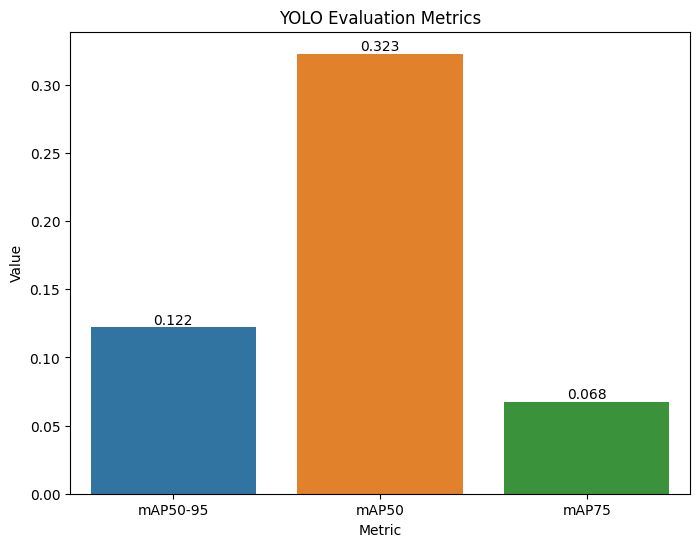

In [10]:
# After training, validate the model to get metrics
results = model.val(data='/kaggle/input/bone-fracture-detection-computer-vision-project/BoneFractureYolo8/data.yaml')

# Access evaluation metrics
map50_95 = results.box.map
map50 = results.box.map50
map75 = results.box.map75

# Create the barplot
ax = sns.barplot(x=['mAP50-95', 'mAP50', 'mAP75'], y=[map50_95, map50, map75])

# Set the title and axis labels
ax.set_title('YOLO Evaluation Metrics')
ax.set_xlabel('Metric')
ax.set_ylabel('Value')

# Set the figure size
fig = plt.gcf()
fig.set_size_inches(8, 6)

# Add the values on top of the bars
for p in ax.patches:
    ax.annotate('{:.3f}'.format(p.get_height()), (p.get_x() + p.get_width() / 2, p.get_height()), ha='center', va='bottom')

# Show the plot
plt.show()


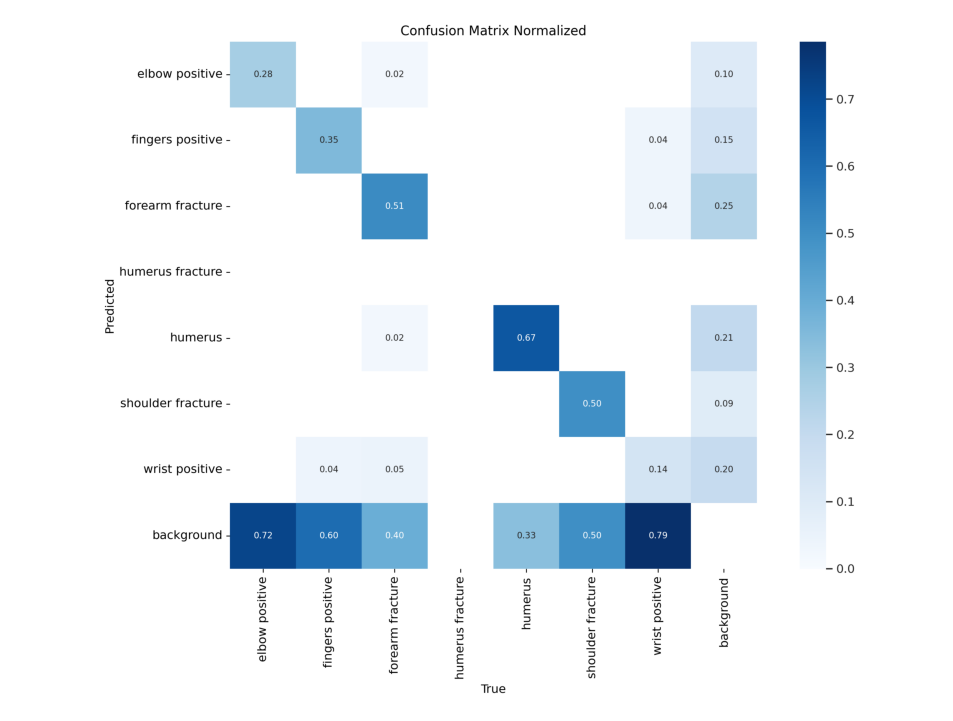

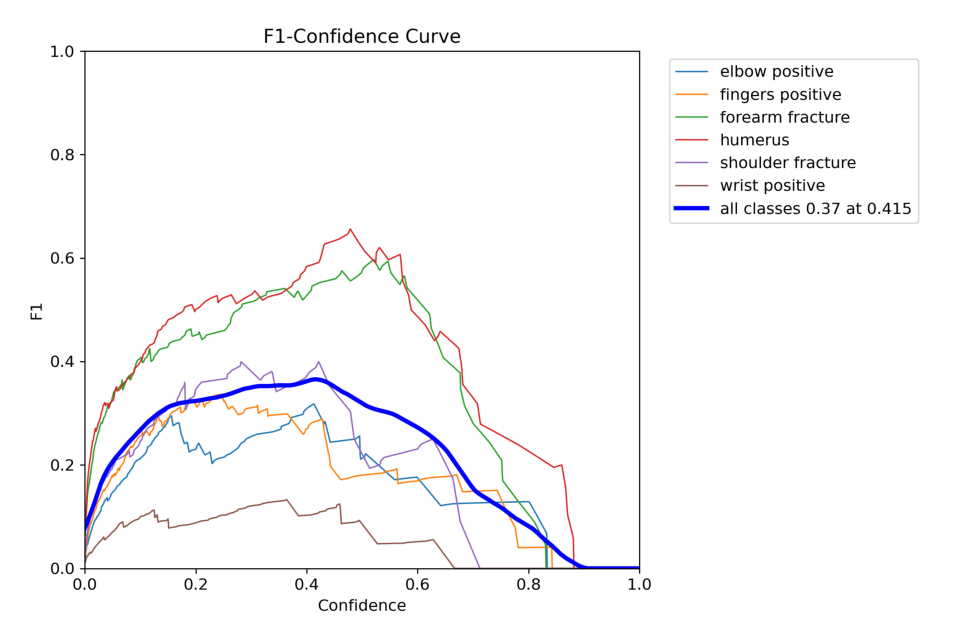

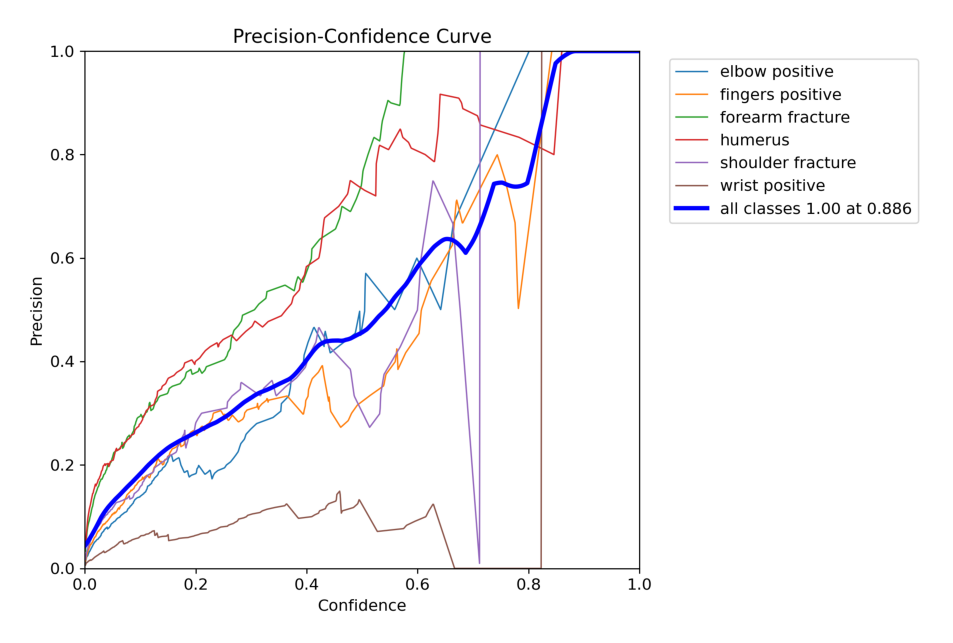

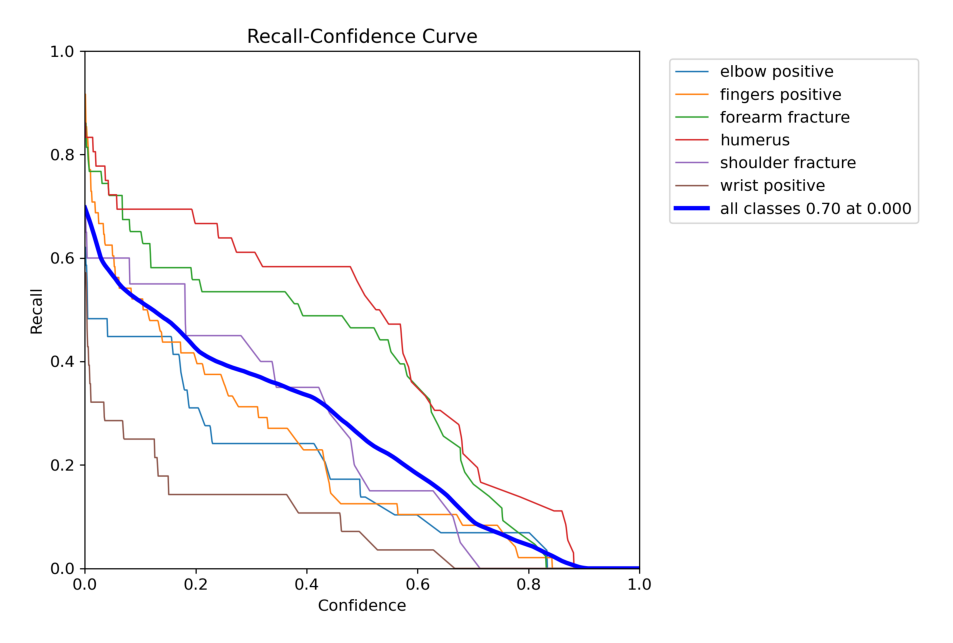

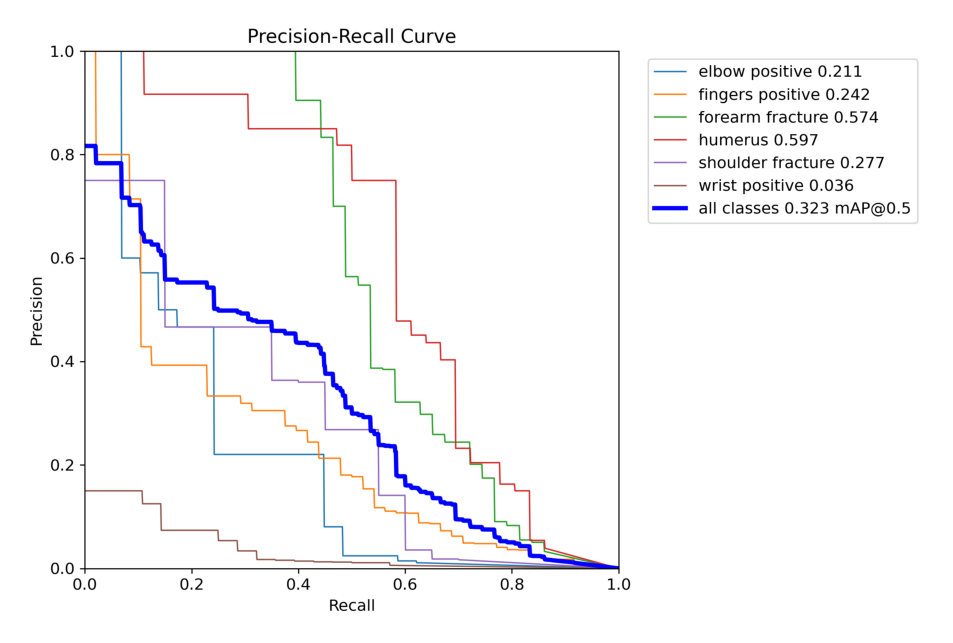

[ WARN:0@493.699] global loadsave.cpp:241 findDecoder imread_('/kaggle/working/runs/detect/train32/results.png'): can't open/read file: check file path/integrity


error: OpenCV(4.10.0) /io/opencv/modules/imgproc/src/color.cpp:196: error: (-215:Assertion failed) !_src.empty() in function 'cvtColor'


In [7]:
# Configure the visual appearance of Seaborn plots
sns.set(rc={'axes.facecolor': '#9b63b8'}, style='darkgrid')

def display_images(post_training_files_path, image_files):
    
    for image_file in image_files:
        image_path = os.path.join(post_training_files_path, image_file)
        img = cv2.imread(image_path)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        
        plt.figure(figsize=(10, 10), dpi=120)
        plt.imshow(img)
        plt.axis('off')
        plt.show()

# List of image files to display
image_files = [
    'confusion_matrix_normalized.png',
    'F1_curve.png',
    'P_curve.png',
    'R_curve.png',
    'PR_curve.png',
    'results.png'
]

# Path to the directory containing the images
post_training_files_path = '/kaggle/working/runs/detect/train32'

# Display the images
display_images(post_training_files_path, image_files)


# 5.prediction on test data



0: 512x640 (no detections), 9.9ms
Speed: 2.1ms preprocess, 9.9ms inference, 1.7ms postprocess per image at shape (1, 3, 512, 640)

0: 544x640 2 shoulder fractures, 8.3ms
Speed: 2.8ms preprocess, 8.3ms inference, 1.2ms postprocess per image at shape (1, 3, 544, 640)

0: 640x640 (no detections), 9.2ms
Speed: 3.0ms preprocess, 9.2ms inference, 0.5ms postprocess per image at shape (1, 3, 640, 640)

0: 640x544 (no detections), 9.4ms
Speed: 2.8ms preprocess, 9.4ms inference, 0.6ms postprocess per image at shape (1, 3, 640, 544)

0: 640x544 (no detections), 7.6ms
Speed: 2.3ms preprocess, 7.6ms inference, 0.6ms postprocess per image at shape (1, 3, 640, 544)

0: 544x640 (no detections), 8.4ms
Speed: 2.8ms preprocess, 8.4ms inference, 0.6ms postprocess per image at shape (1, 3, 544, 640)

0: 640x384 (no detections), 8.8ms
Speed: 2.3ms preprocess, 8.8ms inference, 0.6ms postprocess per image at shape (1, 3, 640, 384)

0: 512x640 (no detections), 8.4ms
Speed: 2.2ms preprocess, 8.4ms inference, 0

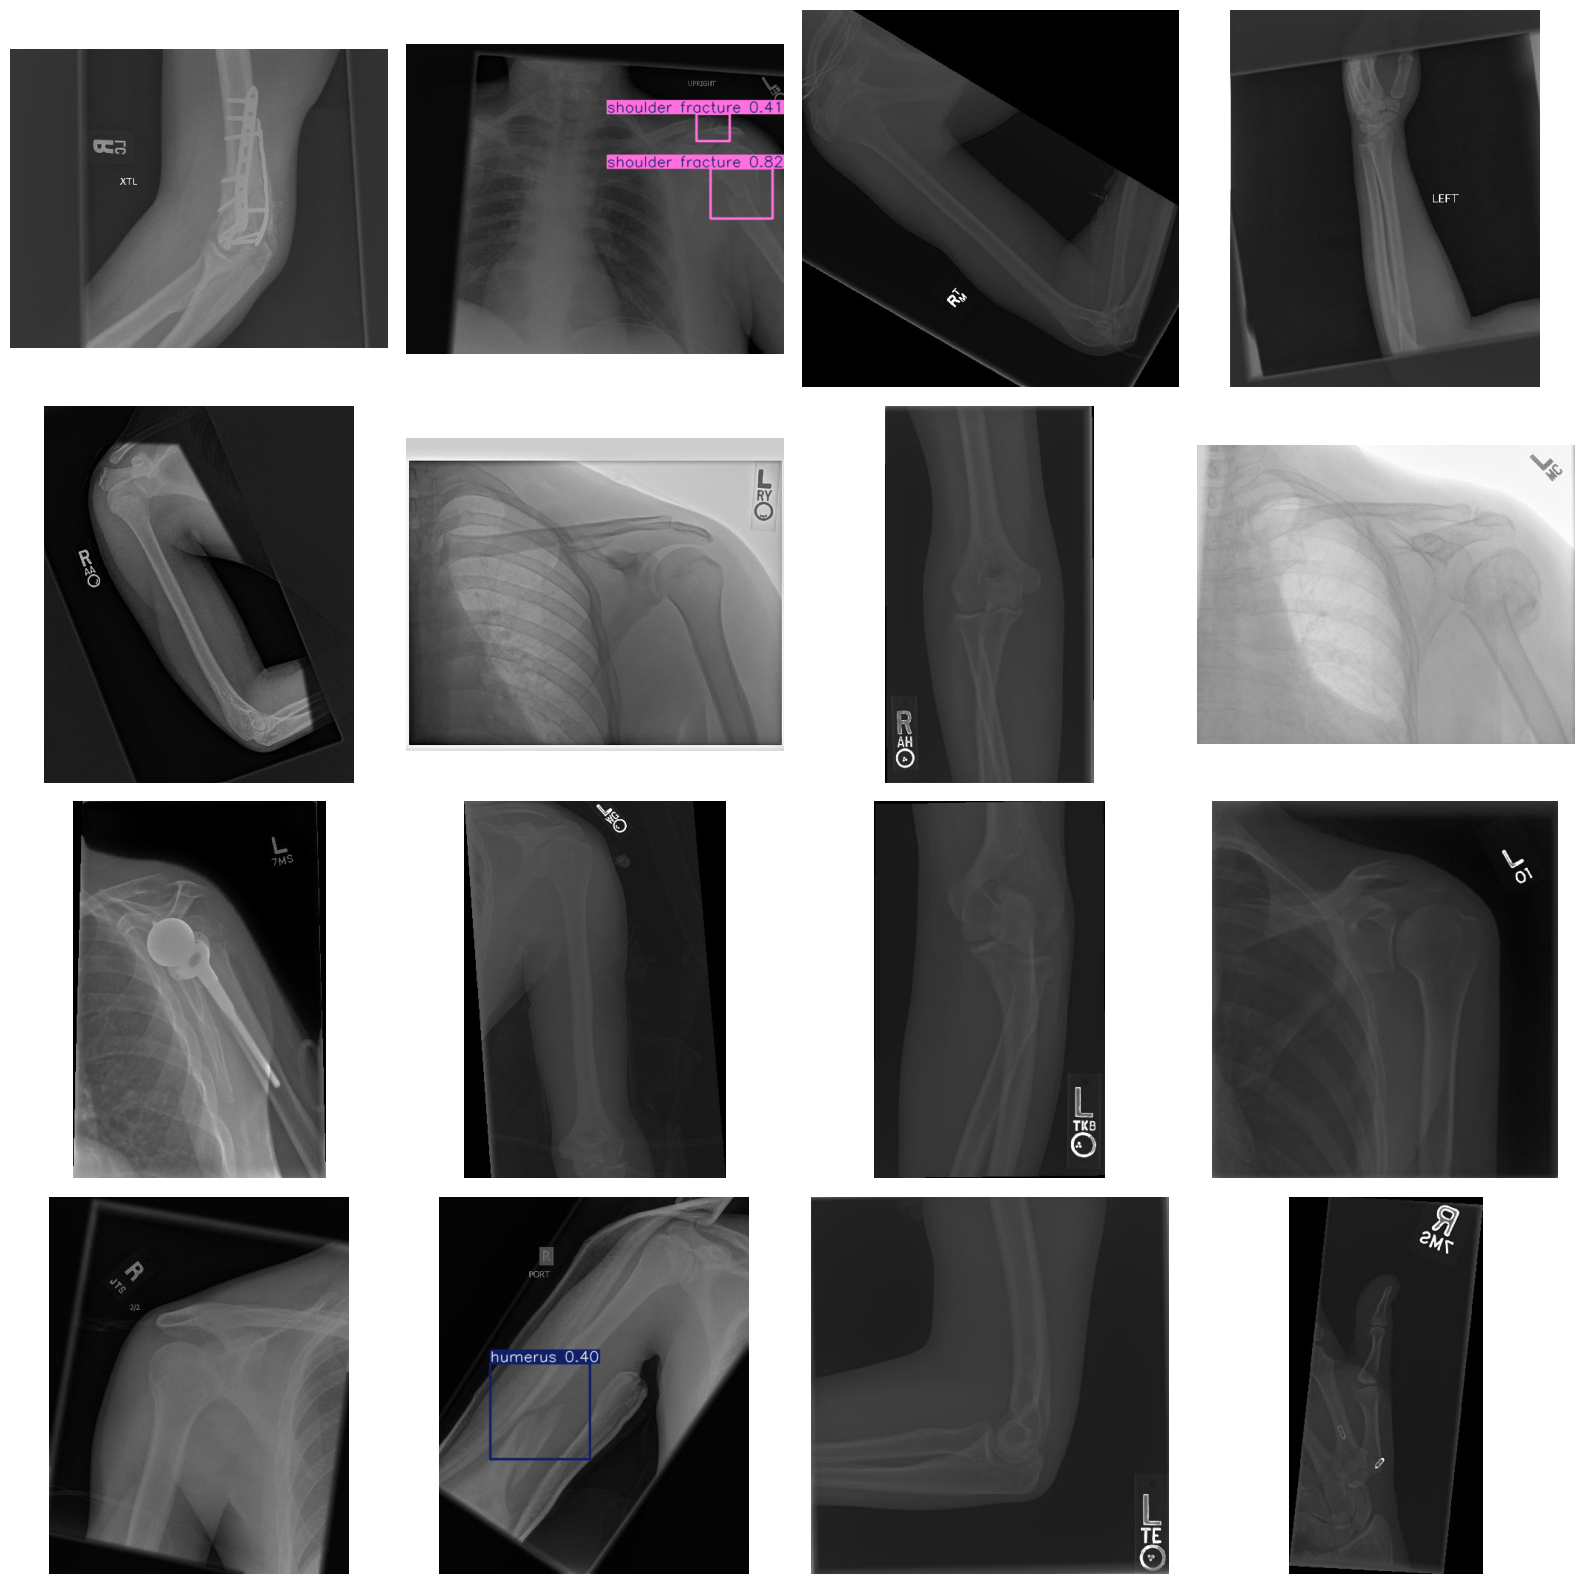

In [13]:
import os
import random
import cv2
import matplotlib.pyplot as plt
from ultralytics import YOLO  # Import YOLO from the ultralytics library

# Load the YOLO model
model_path = '/kaggle/input/best1/pytorch/default/1/best.pt'  # Path to your YOLO model
model = YOLO(model_path)

# Directory where test images are stored
test_images_path = '/kaggle/input/bone-fracture-detection-computer-vision-project/BoneFractureYolo8/test/images/'

# Get a list of all test image files
image_files = os.listdir(test_images_path)

# Choose a random sample of test images
sample_size = 16  # Number of random images to display
random_images = random.sample(image_files, min(sample_size, len(image_files)))  # Ensure no more than available images

# Set up the plot (4x4 grid)
fig, axs = plt.subplots(4, 4, figsize=(16, 16))

# Loop over the random images and process them
for i, image_file in enumerate(random_images):
    row = i // 4
    col = i % 4
    
    # Load the image
    image_path = os.path.join(test_images_path, image_file)
    image = cv2.imread(image_path)

    # Run inference on the image using the YOLO model
    results = model(image)  # Inference directly with the model

    # Get the output image with bounding boxes and labels
    output_image = results[0].plot()  # Plot the image with detections

    # Convert the image from BGR (OpenCV format) to RGB for displaying with Matplotlib
    output_image_rgb = cv2.cvtColor(output_image, cv2.COLOR_BGR2RGB)

    # Display the image with bounding boxes
    axs[row, col].imshow(output_image_rgb)
    axs[row, col].axis('off')  # Turn off axis

# Display all the images
plt.tight_layout()
plt.show()


# 6. Make Predictions on New Data



0: 640x512 2 elbow positives, 44.1ms
Speed: 2.2ms preprocess, 44.1ms inference, 1.2ms postprocess per image at shape (1, 3, 640, 512)


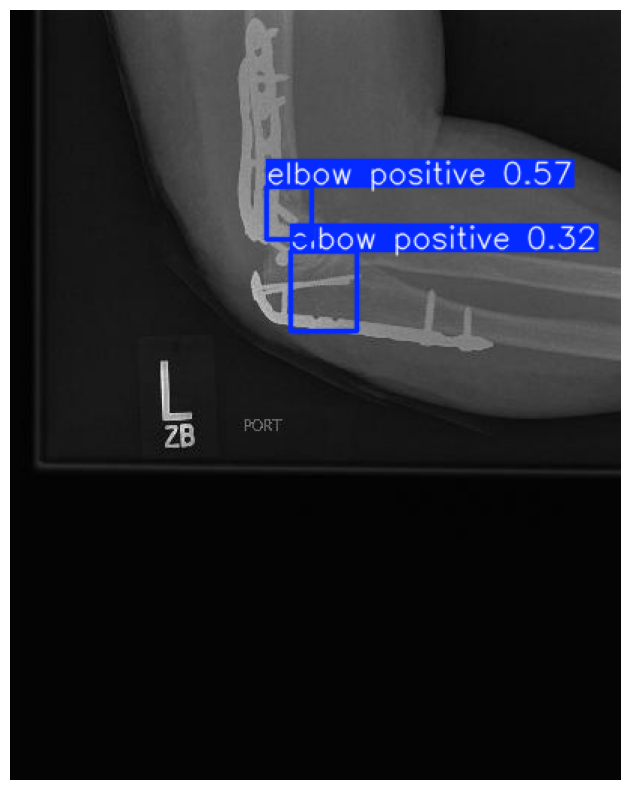

In [4]:
from ultralytics import YOLO  # Import YOLO from the ultralytics library
import cv2
import matplotlib.pyplot as plt

# Step 1: Load the model using the Kaggle path
# model_path = '/kaggle/working/runs/detect/train3/weights/best.pt'  
model_path = '/kaggle/input/best1/pytorch/default/1/best.pt'  

model = YOLO(model_path)  # Load model using the YOLO class from ultralytics

# Step 2: Load a test image using the Kaggle path
# image_path = '/kaggle/input/bone-fracture-detection-computer-vision-project/BoneFractureYolo8/test/images/image1_3073_png.rf.241285b7d595353800440e6d2b9b91f0.jpg'

image_path = '/kaggle/input/bone-fracture-detection-computer-vision-project/BoneFractureYolo8/test/images/image1_2157_png.rf.37cf76e910103b2aa83a2c925849f300.jpg'
image = cv2.imread(image_path)

# Step 3: Run inference on the image using the YOLO model
results = model(image)  # Inference directly with the model

# Step 4: Access the results (bounding boxes, labels, etc.)
# Use the `results` object to get the plotted image
output_image = results[0].plot()  # Plot the image with detections

# Step 5: Convert to RGB for displaying with Matplotlib
output_image_rgb = cv2.cvtColor(output_image, cv2.COLOR_BGR2RGB)

# Step 6: Display the image with bounding boxes
plt.figure(figsize=(10, 10))
plt.imshow(output_image_rgb)
plt.axis('off')  # Turn off axis
plt.show()



0: 544x640 2 shoulder fractures, 43.0ms
Speed: 12.7ms preprocess, 43.0ms inference, 225.2ms postprocess per image at shape (1, 3, 544, 640)


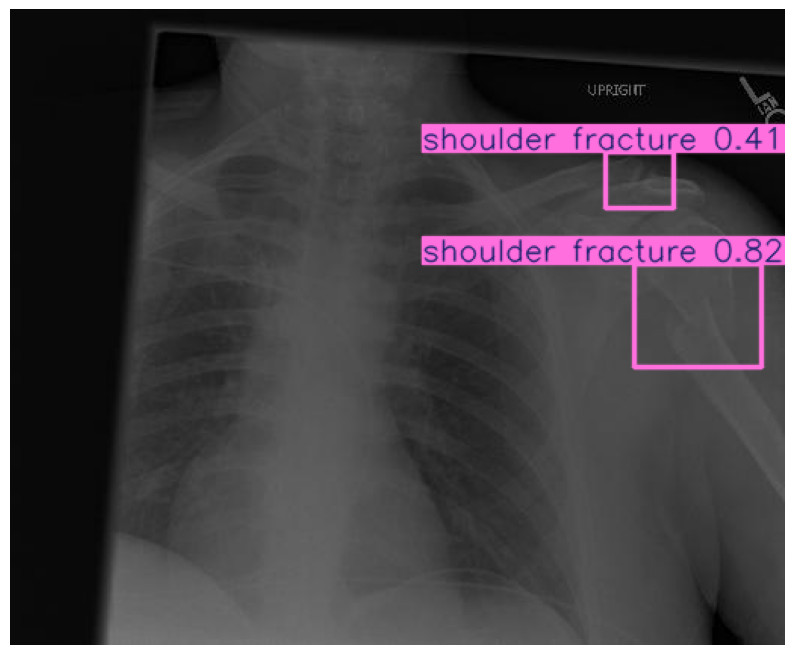

In [6]:
from ultralytics import YOLO  # Import YOLO from the ultralytics library
import cv2
import matplotlib.pyplot as plt

# Step 1: Load the model using the Kaggle path
# model_path = '/kaggle/working/runs/detect/train3/weights/best.pt'  
model_path = '/kaggle/input/best1/pytorch/default/1/best.pt'  

model = YOLO(model_path)  # Load model using the YOLO class from ultralytics

# Step 2: Load a test image using the Kaggle path

image_path = '/kaggle/input/bone-fracture-detection-computer-vision-project/BoneFractureYolo8/test/images/image1_5740_png.rf.9e24e104e841b740e0389637d5e6d2d7.jpg'
image = cv2.imread(image_path)

# Step 3: Run inference on the image using the YOLO model
results = model(image)  # Inference directly with the model

# Step 4: Access the results (bounding boxes, labels, etc.)
# Use the `results` object to get the plotted image
output_image = results[0].plot()  # Plot the image with detections

# Step 5: Convert to RGB for displaying with Matplotlib
output_image_rgb = cv2.cvtColor(output_image, cv2.COLOR_BGR2RGB)

# Step 6: Display the image with bounding boxes
plt.figure(figsize=(10, 10))
plt.imshow(output_image_rgb)
plt.axis('off')  # Turn off axis
plt.show()
